In [ ]:
# for drive access
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import numpy as np
import pandas as pd
import pickle
import time

# for audio
import librosa

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# for saving the label & features to disk
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns


##For Audio Feature Extraction


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/modifiedbird/train_val.csv')

df.head(10)

,primary_label,type,latitude,longitude,scientific_name,common_name,rating,file_name,duration,country,continent,filename_npy,set
0,abethr1,call,-2.9965,37.6244,Turdus tephronotus,African Bare-eyed Thrush,3.0,abethr1/XC432639.ogg,25.392000,KE,AF,abethr1/XC432639.npy,train
1,abethr1,both,-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,4.5,abethr1/XC363504.ogg,42.344500,KE,AF,abethr1/XC363504.npy,train
2,abethr1,song,-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,5.0,abethr1/XC363503.ogg,29.257188,KE,AF,abethr1/XC363503.npy,train
3,abethr1,song,4.8403,38.6988,Turdus tephronotus,African Bare-eyed Thrush,4.0,abethr1/XC531557.ogg,19.931000,ET,AF,abethr1/XC531557.npy,train
4,abethr1,song,-4.0904,37.8807,Turdus tephronotus,African Bare-eyed Thrush,5.0,abethr1/XC467122.ogg,20.688000,TZ,AF,abethr1/XC467122.npy,train
5,abethr1,song,4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,4.0,abethr1/XC128013.ogg,45.609812,ET,AF,abethr1/XC128013.npy,train
6,abethr1,both,-2.9858,37.5975,Turdus tephronotus,African Bare-eyed Thrush,5.0,abethr1/XC639039.ogg,34.011437,KE,AF,abethr1/XC639039.npy,train
7,abethr1,song,NaN,NaN,Turdus tephronotus,African Bare-eyed Thrush,4.0,abethr1/XC585802.ogg,19.464000,UNKNOWN,UNKNOWN,abethr1/XC585802.npy,train
8,abethr1,song,-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,3.5,abethr1/XC363502.ogg,38.765750,KE,AF,abethr1/XC363502.npy,train
9,abethr1,song,-4.0904,37.8807,Turdus tephronotus,African Bare-eyed Thrush,5.0,abethr1/XC467121.ogg,42.631000,TZ,AF,abethr1/XC467121.npy,train


In [ ]:
# prompt: code to select update the df with the csv of top 3 most repeated primary label only from the above loaded csv

# Count occurrences of each primary label
label_counts = df['primary_label'].value_counts()

# Get the top 3 most frequent labels
top_3_labels = label_counts.nlargest(3).index

# Create a boolean mask to select rows with top 3 labels
mask = df['primary_label'].isin(top_3_labels)

# Update the DataFrame with only the top 3 labels
df = df[mask]

In [ ]:
df['primary_label'].nunique()

3

#Self Defined Class Methods For Feature Extraction

In [ ]:
class Framed:

  def __init__(self,
               dataframe,
               sr=16000,
               window_size_s=8.0,
               hop_size_s=4,
               do_augment=True
               ):
    """
    Instantiate the Framed class, create train and val dfs.

    The extract_framed() method is automatically called when the class is
    instantiated to extract the framed audios and add to the train and val dfs.

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information.
      sr (int): Sample rate of the audio files.
      window_size_s (float): Window size in seconds for framing the audio.
      hop_size_s (float): Hop size in seconds for framing the audio.
      augment (bool): Whether to apply augmentation to the audio.
    """
    # instantiate class
    self.sr = sr
    self.frame_length = int(window_size_s * sr)
    self.frame_step = int(hop_size_s * sr)

    # split the dataframe to train and val by calling the _split_train_val() method
    self.train_df, self.val_df = self._split_train_val(dataframe)

    # add framed audios to train and val dfs by calling the extract_framed() method
    # only training data could be augmented, validation is never augmented
    self.extract_framed(self.train_df, augment=do_augment)
    self.extract_framed(self.val_df, augment=False)


  ########################################
  # _split_train_val function is called when the class is instantiated
  ########################################
  def _split_train_val(self,
                       dataframe):
    """
    Split the dataframe to train and val based on predefined 'set' column.

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information.

    Returns:
      tuple: Tuple of train and val dataframes containing audio file information.
    """
    # extract the train set from dataframe & shuffle the train set
    train_df = dataframe[dataframe['set'] == 'train']
    train_df = train_df.sample(frac=1, random_state=1234)

    # extract the val set from dataframe & shuffle the val set
    val_df = dataframe[dataframe['set'] == 'val']
    val_df = val_df.sample(frac=1, random_state=1234)

    return train_df, val_df


  ########################################
  # augment function is called by extract_framed function if do_augment=True
  ########################################
  def augment(self, audio_array):
    """
    Apply random augmentation if needed.

    Parameters:
      audio_array (npy): Training audio array.

    Returns:
      audio_array (npy): Augmented audio array.
    """
    choice = np.random.choice(['original','noise','shift','pitch'])

    # if the audio is short (less than 7 seconds in duration), stretch it first
    if len(audio_array) <= 7*self.sr:
      audio_array = librosa.effects.time_stretch(y=audio_array, rate=np.random.uniform(low=0, high=1))
    # if the audio is not short, apply a random augmentation at random magnitude
    elif choice == 'noise':
      noise_amp = np.random.normal(loc=0.0, scale=0.05)*np.amax(audio_array)
      audio_array = audio_array + noise_amp*np.random.normal(size=audio_array.shape[0])
    elif choice == 'shift':
      shift_range = int(np.random.uniform(low=-5, high=5)*1000)
      audio_array = np.roll(audio_array, shift_range)
    elif choice == 'pitch':
      audio_array = librosa.effects.pitch_shift(y=audio_array, sr=self.sr, n_steps=np.random.uniform(low=0, high=1))
    else:
      audio_array = audio_array

    return audio_array


  ########################################
  # extract_framed function is called when the class is instantiated to extract the framed audios
  ########################################
  def extract_framed(self, dataframe, augment):
    """
    Load audio files from the given DataFrame, extract framed audios,
    and add the framed audios to the given DataFrame

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information.
      augment (bool): Whether to apply augmentation to the audio.
    """
    # load audios
    audios = []
    for filename in dataframe['filename_npy']:
      audio = np.load('/content/drive/MyDrive/modifiedbird/train_npy/' + filename)
      # if augment is true, call the augment function to apply augmentation to the audio
      if augment:
        audio = self.augment(audio)
      audios.append(audio)
    assert len(audios) == len(dataframe)

    # extract framed audios
    framed = []
    for audio in audios:
      framed_audio = tf.signal.frame(audio, self.frame_length, self.frame_step, pad_end=False)
      framed.append(framed_audio)
    assert len(framed) == len(audios)

    # add framed audios to df
    dataframe['framed'] = framed

In [ ]:
len(df)

150

#Extract train and val dfs with framed audios

In [ ]:
filtered = df[df['duration'] < 10.0]

filtered

,primary_label,type,latitude,longitude,scientific_name,common_name,rating,file_name,duration,country,continent,filename_npy,set
2775,sccsun2,call,9.5811,-5.3874,Chalcomitra senegalensis,Scarlet-chested Sunbird,5.0,sccsun2/XC380521.ogg,7.157563,CI,AF,sccsun2/XC380521.npy,train
2779,sccsun2,blank,-1.8495,36.8708,Chalcomitra senegalensis,Scarlet-chested Sunbird,5.0,sccsun2/XC753434.ogg,5.799188,KE,AF,sccsun2/XC753434.npy,train
2785,sccsun2,call,-2.9858,37.5975,Chalcomitra senegalensis,Scarlet-chested Sunbird,5.0,sccsun2/XC645219.ogg,3.144000,KE,AF,sccsun2/XC645219.npy,train
2823,reccuc1,song,-2.9858,37.5975,Cuculus solitarius,Red-chested Cuckoo,5.0,reccuc1/XC607153.ogg,9.744000,KE,AF,reccuc1/XC607153.npy,train
2825,reccuc1,song,-2.8145,37.4113,Cuculus solitarius,Red-chested Cuckoo,5.0,reccuc1/XC397760.ogg,5.276000,KE,AF,reccuc1/XC397760.npy,train
2833,reccuc1,song,-2.9858,37.5975,Cuculus solitarius,Red-chested Cuckoo,5.0,reccuc1/XC607234.ogg,8.376000,KE,AF,reccuc1/XC607234.npy,train
2851,reccuc1,song,-0.6306,34.2962,Cuculus solitarius,Red-chested Cuckoo,4.0,reccuc1/XC537203.ogg,8.071875,KE,AF,reccuc1/XC537203.npy,train
2852,reccuc1,song,1.7112,31.5421,Cuculus solitarius,Red-chested Cuckoo,4.0,reccuc1/XC430359.ogg,4.780000,UG,AF,reccuc1/XC430359.npy,train
2853,reccuc1,song,0.4830,30.3890,Cuculus solitarius,Red-chested Cuckoo,4.0,reccuc1/XC263039.ogg,7.601625,UG,AF,reccuc1/XC263039.npy,train
2864,egygoo,call,50.4631,3.6638,Alopochen aegyptiaca,Egyptian Goose,5.0,egygoo/XC585946.ogg,6.582000,BE,EU,egygoo/XC585946.npy,train


In [ ]:
df.drop(filtered.index, inplace=True)

In [ ]:
assert len(df[df['duration'] < 8.0]) == 0

In [ ]:
%%time

framed = Framed(df,
               window_size_s=8.0,
               hop_size_s=4.0,
               do_augment=True)

CPU times: user 18.1 s, sys: 1.72 s, total: 19.8 s
Wall time: 1min 4s


##View the train_df with framed audios for future use

In [ ]:
framed.train_df.head()

,primary_label,type,latitude,longitude,scientific_name,common_name,rating,file_name,duration,country,continent,filename_npy,set,framed
2866,egygoo,call,52.2704,13.7252,Alopochen aegyptiaca,Egyptian Goose,5.0,egygoo/XC402519.ogg,16.065313,DE,EU,egygoo/XC402519.npy,train,"((tf.Tensor(-0.0008935826, shape=(), dtype=flo..."
2867,egygoo,call,52.3616,7.0626,Alopochen aegyptiaca,Egyptian Goose,5.0,egygoo/XC474526.ogg,27.454687,NL,EU,egygoo/XC474526.npy,train,"((tf.Tensor(0.010603871757674056, shape=(), dt..."
2900,egygoo,call,-33.3155,26.1085,Alopochen aegyptiaca,Egyptian Goose,4.0,egygoo/XC315025.ogg,27.984000,ZA,AF,egygoo/XC315025.npy,train,"((tf.Tensor(0.0073181224369550275, shape=(), d..."
2898,egygoo,call,25.7054,-80.1570,Alopochen aegyptiaca,Egyptian Goose,4.0,egygoo/XC315564.ogg,35.976000,US,NaN,egygoo/XC315564.npy,train,"((tf.Tensor(0.00033781928, shape=(), dtype=flo..."
2782,sccsun2,call,-2.9858,37.5975,Chalcomitra senegalensis,Scarlet-chested Sunbird,5.0,sccsun2/XC620843.ogg,42.432000,KE,AF,sccsun2/XC620843.npy,train,"((tf.Tensor(-0.0020933535, shape=(), dtype=flo..."


In [ ]:
class Extraction:

  def __init__(self,
               train_df,
               val_df,
               sr=16000,
               n_mfccs=20, #20 is the default n_mfccs from librosa
               n_mels=20, #reduced from 128 default from librosa to 20
               n_chroma=12, #12 is the default n_chroma from librosa
               features=['mfcc','rms'],
               do_normalize=True,
               do_avgpool=True #WARNING: THE KERNEL WILL CRASH IF YOU TRY TO EXTRACT ALL FEATURES WITHOUT AVGPOOL
               ):
    """
    Instantiate the Extraction class and extract the labels and features from train and val DataFrames.

    The extract_features() method is automatically called to extract the labels and features from the given DataFrame.

    Parameters:
      train_df (pd.DataFrame): DataFrame containing training data.
      val_df (pd.DataFrame): DataFrame containing validation data.
      sr (int): Sample rate of the audio files.
      n_mfccs (int): Number of MFCCs to extract.
      n_mels (int): Number of Mel bands to extract.
      n_chroma (int): Number of chroma bins to use.
      features (list): List of features to extract.
        accepted features: 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating', 'type'.
      normalize (bool): Whether to normalize the features.
      maxpool (bool): Whether to maxpool the features.
    """
    # instantiate class variables
    self.sr = sr
    self.n_mfccs = n_mfccs
    self.n_mels = n_mels
    self.n_chroma = n_chroma
    self.do_normalize = do_normalize
    self.do_avgpool = do_avgpool

    # confirm features have been specified
    assert len(features) != 0, "Must Specify At Least One Feature In The Form Of A List."
    self.features = features

    # confirm features are valid
    self.accepted_feature = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating', 'type']
    for each in self.features:
      assert each in self.accepted_feature, f"{each} is not an accepted feature, only 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating', and 'type' are accpeted features."

    # extract train and val labels and features
    self.train_y, self.train_features = self.extract_features(train_df)
    self.val_y, self.val_features = self.extract_features(val_df)

    # process the features by applying normalization or average pooling
    self.train_features, self.val_features = self.process_features(self.train_features, self.val_features)


  ########################################
  # each of the extract_x() function is callable by the extract_features() function based on the features instantiated
  # each of the features are extracted from librosa and transposed to shape (n_time, n_features)
  ########################################
  def extract_mfcc(self, each):
    return np.transpose(librosa.feature.mfcc(y=np.array(each), sr=self.sr, n_mfcc=self.n_mfccs))

  def extract_chroma(self, each):
    return np.transpose(librosa.feature.chroma_stft(y=np.array(each), sr=self.sr, n_chroma=self.n_chroma))

  def extract_rms(self, each):
    return np.transpose(librosa.feature.rms(y=np.array(each)))

  def extract_spectral_centroid(self, each):
    return np.transpose(librosa.feature.spectral_centroid(y=np.array(each), sr=self.sr))

  def extract_melspectrogram(self, each):
    mel = librosa.feature.melspectrogram(y=np.array(each), sr=self.sr, n_mels=self.n_mels)
    return np.transpose(librosa.power_to_db(mel))


  ########################################
  # normalization function is called by process_features() function for the features that require normalization
  ########################################
  def normalization(self, train_X, val_X, n_time, n_features):
    """
    Normalize the train and val features

    Parameters:
      train_X (npy): Training feature
      val_X (npy): Validation feature
      n_time (int): Time axis
      n_features (int): Feature axis

    Returns:
      train_X (npy): Normalized training feature
      val_X (npy): Normalized validation feature
    """
    # flatten the np arrays to 1D
    train_X_reshape = train_X.reshape(-1, n_time * n_features)
    val_X_reshape = val_X.reshape(-1, n_time * n_features)

    # use minmaxscaler to normalize the train and val features
    scaler = MinMaxScaler((0,1)).fit(train_X_reshape)
    train_X_scaled = scaler.transform(train_X_reshape)
    val_X_scaled = scaler.transform(val_X_reshape)

    # reshape the features to the original shape (n_time, n_features)
    train_X = train_X_scaled.reshape(-1, n_time, n_features)
    val_X = val_X_scaled.reshape(-1, n_time, n_features)

    return train_X, val_X


  ########################################
  # avgpooling function is called by process_features() function for the features that require average pooling
  ########################################
  def avgpooling(self, train_X, val_X, n_time, n_features):
    """
    Average pooling the train and val features

    Parameters:
      train_X (npy): Training feature
      val_X (npy): Validation feature
      n_time (int): Time axis
      n_features (int): Feature axis

    Returns:
      train_X (npy): Avgpooled training feature
      val_X (npy): Avgpooled validation feature
    """
    # instantiate the keras layers and model.
    # the model only performs average pooling of inputs
    tf.keras.backend.clear_session()
    input = tf.keras.layers.Input(shape=(n_time, n_features))
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
    pooled = global_avg_pooling(input)
    pooling_model = tf.keras.models.Model(inputs=input, outputs=pooled)

    # use the instantiated model to avgpool the train and val features
    train_X = pooling_model.predict(train_X)
    val_X = pooling_model.predict(val_X)

    return train_X, val_X


  ########################################
  # process_features function is called when the class is instantiated
  ########################################
  def process_features(self, train_features_dict, val_features_dict):
    """
    Apply normalization or average pooling to train and val features

    Parameters:
      train_features_dict (dict): Dictionary containing the training features
      val_features_dict (dict): Dictionary containing the validation features

    Returns:
      tuple: Tuple containing normalized and/or average pooled training and validation features dictionary
    """
    start_time = time.time()
    display('features processing started ---------->')

    for each in train_features_dict.keys():
      # 'continent', 'rating', and 'type' do not need to be processed
      if each == 'continent' or each == 'rating' or each == 'type':
        pass
      # process numeric features
      else:
        if each == 'mfcc':
          n_features=self.n_mfccs
        elif each == 'chroma':
          n_features=self.n_chroma
        elif each == 'rms' or each == 'spectral_centroid':
          n_features=1
        elif each == 'melspectrogram':
          n_features=self.n_mels

        # index the dictionary to find the value of the feature based on the feature name (key)
        train_feature = train_features_dict[each]
        val_feature = val_features_dict[each]

        # call normalization or avgpooling function to apply normalization or average pooling to features
        if self.do_normalize and self.do_avgpool:
          train_features_dict[each], val_features_dict[each] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=n_features)
          train_features_dict[each], val_features_dict[each] = self.avgpooling(train_features_dict[each], val_features_dict[each], n_time=train_feature.shape[1], n_features=n_features)
        elif self.do_normalize:
          train_features_dict[each], val_features_dict[each] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=n_features)
        elif self.do_avgpool:
          train_features_dict[each], val_features_dict[each] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=n_features)
        else:
          train_features_dict[each], val_features_dict[each] = train_features_dict[each], val_features_dict[each]

        display(f'{each} processed')

    end_time = time.time()
    display(f'features processing took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, val_features_dict


  ########################################
  # extract_features function is called when the class is instantiated
  ########################################
  def extract_features(self, dataframe):
    """
    Extract the label & features from the dataframes

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information

    Returns:
      tuple: Tuple containing labels and a dictionary of extracted features
    """
    start_time = time.time()
    display(f'feature extraction started ---------->')

    # create empty list and dict to store the labels and features
    y = []
    features_dict = {item: [] for item in self.features}

    # iterate through each row of the dataframe to extract the label and features
    for _, row in dataframe.iterrows():
      label = row['primary_label']
      framed = row['framed']

      for each in framed:
        y.append(label)

        if 'continent' in self.features:
          features_dict['continent'].append(row['continent'])
        if 'rating' in self.features:
          features_dict['rating'].append(row['rating'])
        if 'type' in self.features:
          features_dict['type'].append(row['type'])

        # dynatically call the extract_x function to extract the listed features
        for feature in self.features:
          extract = f"extract_{feature}"
          if hasattr(self, extract) and callable(func := getattr(self, extract)):
            features_dict[feature].append(func(each))

    # cast lists to np arrays
    for each in features_dict.keys():
      features_dict[each] = np.array(features_dict[each])
    y = np.array(y)

    end_time = time.time()
    display(f'features extraction took {(end_time - start_time)/60:.1f} mins')

    return y, features_dict


#Extracting Features


In [ ]:
features_list = ['mfcc', 'rms', 'melspectrogram']
#  'chroma','spectral_centroid',

In [ ]:

%%time

features = Extraction(framed.train_df,
                      framed.val_df,
                      features=features_list,
                      do_normalize=True,
                      do_avgpool=False)

'feature extraction started ---------->'

'features extraction took 0.8 mins'

'feature extraction started ---------->'

'features extraction took 0.1 mins'

'features processing started ---------->'

'mfcc processed'

'rms processed'

'melspectrogram processed'

'features processing took 0.0 mins'

CPU times: user 1min 41s, sys: 4min 58s, total: 6min 40s
Wall time: 51.2 s


In [ ]:
train_y = features.train_y

display(train_y.shape)
display(train_y[:5])

(897,)

array(['egygoo', 'egygoo', 'egygoo', 'egygoo', 'egygoo'], dtype='<U7')

In [ ]:

train_features = features.train_features

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'mfcc'

(897, 251, 20)

array([[0.45196299, 0.86899774, 0.76724797, ..., 0.4930924 , 0.31372398,
        0.38404111],
       [0.4643291 , 0.8451906 , 0.71392004, ..., 0.49891251, 0.32523724,
        0.43230885],
       [0.51317713, 0.74132754, 0.64648704, ..., 0.54218557, 0.41009619,
        0.40439876],
       ...,
       [0.73528198, 0.47100205, 0.45628491, ..., 0.53008509, 0.18556476,
        0.34542718],
       [0.73088355, 0.48112267, 0.41364   , ..., 0.51763292, 0.21784972,
        0.32982119],
       [0.70441276, 0.49458846, 0.3648672 , ..., 0.42939997, 0.31305707,
        0.29767795]])

'rms'

(897, 251, 1)

array([[0.00738203],
       [0.00890564],
       [0.02683961],
       [0.06703743],
       [0.10012889],
       [0.09938955],
       [0.09097028],
       [0.08663682],
       [0.0623696 ],
       [0.03231403],
       [0.01885636],
       [0.01806521],
       [0.01587706],
       [0.01501755],
       [0.01626847],
       [0.0149024 ],
       [0.01616124],
       [0.01544973],
       [0.02295032],
       [0.07583997],
       [0.10130966],
       [0.06970537],
       [0.0543941 ],
       [0.03536914],
       [0.01912833],
       [0.0181917 ],
       [0.01563746],
       [0.01516   ],
       [0.02189402],
       [0.02133607],
       [0.01650657],
       [0.01221833],
       [0.00921756],
       [0.01036953],
       [0.03704635],
       [0.08211174],
       [0.07572323],
       [0.07475153],
       [0.0705627 ],
       [0.03255666],
       [0.01631417],
       [0.01480088],
       [0.01133202],
       [0.01211118],
       [0.01094888],
       [0.01068889],
       [0.01468409],
       [0.016

'melspectrogram'

(897, 251, 20)

array([[0.64159768, 0.66048337, 0.66279302, ..., 0.37058073, 0.34797969,
        0.34992692],
       [0.66890187, 0.68062175, 0.68075072, ..., 0.37911204, 0.35675489,
        0.35735337],
       [0.66225354, 0.68087862, 0.72434513, ..., 0.38930736, 0.40496672,
        0.3781762 ],
       ...,
       [0.67081577, 0.65532292, 0.6146544 , ..., 0.73619529, 0.70946482,
        0.65181474],
       [0.64291948, 0.63980189, 0.61187014, ..., 0.68767503, 0.68250558,
        0.6474197 ],
       [0.59414314, 0.63749418, 0.65812162, ..., 0.69094839, 0.70997881,
        0.61031804]])

In [ ]:
val_y = features.val_y
val_y = np.array(val_y)

display(val_y.shape)
display(val_y[:5])

(71,)

array(['egygoo', 'sccsun2', 'sccsun2', 'sccsun2', 'sccsun2'], dtype='<U7')

In [ ]:
val_features = features.val_features

for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'mfcc'

(71, 251, 20)

array([[0.19040102, 0.58338815, 0.68049186, ..., 0.5335268 , 0.45109367,
        0.43933716],
       [0.20430182, 0.68989   , 0.75477374, ..., 0.42060453, 0.35851246,
        0.42290965],
       [0.30724877, 0.72321707, 0.66339153, ..., 0.38438863, 0.42418787,
        0.47768667],
       ...,
       [0.56706166, 0.733975  , 0.5881151 , ..., 0.51443225, 0.36562666,
        0.52066505],
       [0.52079415, 0.7744016 , 0.6075009 , ..., 0.518576  , 0.49187276,
        0.47313562],
       [0.49341595, 0.808817  , 0.6459578 , ..., 0.47188896, 0.5635281 ,
        0.4590536 ]], dtype=float32)

'rms'

(71, 251, 1)

array([[1.26469211e-04],
       [9.81974299e-04],
       [2.10356223e-03],
       [5.76408720e-03],
       [9.46552027e-03],
       [1.15595143e-02],
       [1.36097204e-02],
       [1.85883809e-02],
       [2.31122989e-02],
       [2.65848618e-02],
       [2.45502759e-02],
       [2.59425920e-02],
       [2.90683415e-02],
       [3.14772055e-02],
       [3.36215533e-02],
       [3.29647772e-02],
       [3.23753357e-02],
       [3.23964171e-02],
       [3.21001485e-02],
       [3.63289043e-02],
       [3.40319313e-02],
       [2.18851827e-02],
       [1.71073284e-02],
       [1.46672679e-02],
       [1.37548130e-02],
       [1.40695758e-02],
       [1.69463810e-02],
       [2.07835436e-02],
       [2.84895767e-02],
       [2.80307569e-02],
       [2.29501873e-02],
       [1.88843962e-02],
       [1.77396536e-02],
       [2.05020551e-02],
       [2.15303563e-02],
       [2.94592399e-02],
       [2.75698267e-02],
       [2.68854368e-02],
       [2.94061806e-02],
       [2.96462122e-02],


'melspectrogram'

(71, 251, 20)

array([[0.14448856, 0.12937303, 0.12896177, ..., 0.1309648 , 0.140738  ,
        0.14875308],
       [0.39771616, 0.35254285, 0.33515772, ..., 0.1032022 , 0.10883947,
        0.1171301 ],
       [0.50121886, 0.47146484, 0.48442453, ..., 0.19174635, 0.15583286,
        0.12587458],
       ...,
       [0.68897396, 0.686103  , 0.65511125, ..., 0.3942381 , 0.4023402 ,
        0.37644863],
       [0.6888173 , 0.7153515 , 0.66734225, ..., 0.3406501 , 0.33586523,
        0.3287308 ],
       [0.6940482 , 0.71247643, 0.68132937, ..., 0.34244475, 0.35165396,
        0.33036995]], dtype=float32)

In [ ]:
label_encoder = LabelEncoder().fit(train_y)
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)

classes = list(label_encoder.inverse_transform([]))#Need To change in this part
classes

[]

In [ ]:
display(len(train_y))
display(train_y[:10])

display(len(val_y))
display(val_y[:10])


897

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

71

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
train_features['label'] = train_y
train_features

{'mfcc': array([[[0.45196299, 0.86899774, 0.76724797, ..., 0.4930924 ,
          0.31372398, 0.38404111],
         [0.4643291 , 0.8451906 , 0.71392004, ..., 0.49891251,
          0.32523724, 0.43230885],
         [0.51317713, 0.74132754, 0.64648704, ..., 0.54218557,
          0.41009619, 0.40439876],
         ...,
         [0.73528198, 0.47100205, 0.45628491, ..., 0.53008509,
          0.18556476, 0.34542718],
         [0.73088355, 0.48112267, 0.41364   , ..., 0.51763292,
          0.21784972, 0.32982119],
         [0.70441276, 0.49458846, 0.3648672 , ..., 0.42939997,
          0.31305707, 0.29767795]],
 
        [[0.4393311 , 0.86458521, 0.71105676, ..., 0.57686386,
          0.47179152, 0.45686834],
         [0.45373075, 0.81285538, 0.65925663, ..., 0.62496475,
          0.43849502, 0.45489531],
         [0.60464377, 0.58836617, 0.54535105, ..., 0.48672029,
          0.29762674, 0.45381986],
         ...,
         [0.51195483, 0.66808846, 0.51322367, ..., 0.45506389,
          0.5337

In [ ]:
val_features['label'] = val_y
val_features

{'mfcc': array([[[ 0.19040102,  0.58338815,  0.68049186, ...,  0.5335268 ,
           0.45109367,  0.43933716],
         [ 0.20430182,  0.68989   ,  0.75477374, ...,  0.42060453,
           0.35851246,  0.42290965],
         [ 0.30724877,  0.72321707,  0.66339153, ...,  0.38438863,
           0.42418787,  0.47768667],
         ...,
         [ 0.56706166,  0.733975  ,  0.5881151 , ...,  0.51443225,
           0.36562666,  0.52066505],
         [ 0.52079415,  0.7744016 ,  0.6075009 , ...,  0.518576  ,
           0.49187276,  0.47313562],
         [ 0.49341595,  0.808817  ,  0.6459578 , ...,  0.47188896,
           0.5635281 ,  0.4590536 ]],
 
        [[ 0.29439706,  0.6577764 ,  0.65328217, ...,  0.54723924,
           0.3891843 ,  0.38000563],
         [ 0.46514305,  0.6816832 ,  0.56777805, ...,  0.5872497 ,
           0.28956845,  0.53293014],
         [ 0.5363484 ,  0.5932922 ,  0.5656139 , ...,  0.5440023 ,
           0.41437033,  0.59484076],
         ...,
         [ 0.5131488 ,  0

In [ ]:
audio_df = {'train': train_features, 'val': val_features}

audio_df

{'train': {'mfcc': array([[[0.45196299, 0.86899774, 0.76724797, ..., 0.4930924 ,
           0.31372398, 0.38404111],
          [0.4643291 , 0.8451906 , 0.71392004, ..., 0.49891251,
           0.32523724, 0.43230885],
          [0.51317713, 0.74132754, 0.64648704, ..., 0.54218557,
           0.41009619, 0.40439876],
          ...,
          [0.73528198, 0.47100205, 0.45628491, ..., 0.53008509,
           0.18556476, 0.34542718],
          [0.73088355, 0.48112267, 0.41364   , ..., 0.51763292,
           0.21784972, 0.32982119],
          [0.70441276, 0.49458846, 0.3648672 , ..., 0.42939997,
           0.31305707, 0.29767795]],
  
         [[0.4393311 , 0.86458521, 0.71105676, ..., 0.57686386,
           0.47179152, 0.45686834],
          [0.45373075, 0.81285538, 0.65925663, ..., 0.62496475,
           0.43849502, 0.45489531],
          [0.60464377, 0.58836617, 0.54535105, ..., 0.48672029,
           0.29762674, 0.45381986],
          ...,
          [0.51195483, 0.66808846, 0.51322367, ..

##For non Audio Feature


In [ ]:
# May add sth

In [ ]:

NonAudiofeatures_list = ['type','continent','rating']

In [ ]:
%%time

NonAudiofeatures = Extraction(framed.train_df,
                      framed.val_df,
                      features=NonAudiofeatures_list,
                      do_normalize=False,
                      do_avgpool=False)

'feature extraction started ---------->'

'features extraction took 0.0 mins'

'feature extraction started ---------->'

'features extraction took 0.0 mins'

'features processing started ---------->'

'features processing took 0.0 mins'

CPU times: user 244 ms, sys: 1.07 ms, total: 245 ms
Wall time: 244 ms


In [ ]:

NonAudio_train_y = NonAudiofeatures.train_y

display(NonAudio_train_y.shape)
display(NonAudio_train_y[:5])

(897,)

array(['egygoo', 'egygoo', 'egygoo', 'egygoo', 'egygoo'], dtype='<U7')

In [ ]:

NonAudio_train_features = NonAudiofeatures.train_features

for key in NonAudio_train_features.keys():
  display(key)
  display(NonAudio_train_features[key].shape)
  display(NonAudio_train_features[key][0])

'type'

(897,)

'call'

'continent'

(897,)

'EU'

'rating'

(897,)

5.0

In [ ]:

NonAudio_val_y = NonAudiofeatures.val_y
NonAudio_val_y = np.array(val_y)

display(val_y.shape)
display(val_y[:5])

(71,)

array([0, 2, 2, 2, 2])

In [ ]:
NonAudio_val_features = NonAudiofeatures.val_features

for key in NonAudio_val_features.keys():
  display(key)
  display(NonAudio_val_features[key].shape)
  display(NonAudio_val_features[key][0])

'type'

(71,)

'call'

'continent'

(71,)

'EU'

'rating'

(71,)

5.0

encode class for non audio


In [ ]:
NonAudio_label_encoder = LabelEncoder().fit(NonAudio_train_y)
NonAudio_train_y = NonAudio_label_encoder.transform(NonAudio_train_y)

# Convert NonAudio_val_y to numerical type before transformation
NonAudio_val_y = NonAudio_val_y.astype(int) # add this line
NonAudio_val_y = NonAudio_label_encoder.transform(NonAudio_val_y)

classes = list(NonAudio_label_encoder.inverse_transform([0,1,2])) # Also, changed label_encoder to NonAudio_label_encoder
classes

[0, 1, 2]

In [ ]:

display(len(NonAudio_train_y))
display(NonAudio_train_y[:10])

display(len(NonAudio_val_y))
display(NonAudio_val_y[:10])

897

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

71

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:

NonAudio_train_features['label'] = NonAudio_train_y
NonAudio_train_features

{'type': array(['call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'song',
        'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
        'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'song', 'song',
        'song', 'song', 'song', 'song', 'song', 'call', 'call', 'call',
        'call', 'call', 'call', 'song', 'song', 'call', 'song', 'song',
        'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
        'song', 'song', 'song', 'song', 'song', 'both', 

In [ ]:

NonAudio_val_features['label'] = NonAudio_val_y
NonAudio_val_features

{'type': array(['call', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
        'song', 'song', 'song', 'song', 'song', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'song', 'song', 'song', 'song',
        'song', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
        'call', 'call', 'call', 'call', 'song', 'song', 'song', 'call',
        'call', 'call', 'call', 'call', 'song', 'song', 'song', 'song',
        'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
        'song', 'song', 'call', 'call', 'call', 'call', 'call'],
       dtype='<U4'),
 'continent': array(['EU', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF',
        'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF',
        'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF', 'AF',
        'AF', 'AF', 'AF', 'AF', 'AF', 'EU', 'EU', 'EU', 'EU', 'EU', 'EU',
        'AF', 'AF', '

In [ ]:

non_audio_df = {'train': NonAudio_train_features, 'val': NonAudio_val_features}

non_audio_df

{'train': {'type': array(['call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
         'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
         'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
         'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
         'call', 'call', 'call', 'call', 'call', 'call', 'call', 'song',
         'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
         'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
         'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
         'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call',
         'call', 'call', 'call', 'call', 'call', 'call', 'song', 'song',
         'song', 'song', 'song', 'song', 'song', 'call', 'call', 'call',
         'call', 'call', 'call', 'song', 'song', 'call', 'song', 'song',
         'song', 'song', 'song', 'song', 'song', 'song', 'song', 'song',
         'song', 'song', 'song', '

#Saving the merge_dict


In [ ]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [ ]:

assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

In [ ]:

def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [ ]:

audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [ ]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(897, 251, 20)

array([[[0.34700182, 0.28016264, 0.56960338, ..., 0.60247644,
         0.41483461, 0.36283095],
        [0.28722083, 0.23490831, 0.51982984, ..., 0.55516243,
         0.46255796, 0.44492211],
        [0.2957772 , 0.14070252, 0.48216409, ..., 0.5550645 ,
         0.53987808, 0.48690413],
        ...,
        [0.26434151, 0.03467127, 0.47733767, ..., 0.40315067,
         0.56332721, 0.37052717],
        [0.23414093, 0.09303342, 0.467913  , ..., 0.51187471,
         0.55632966, 0.41539124],
        [0.30018084, 0.13741661, 0.51122971, ..., 0.4901875 ,
         0.59022481, 0.48296536]],

       [[0.64492515, 0.81971499, 0.52067613, ..., 0.52485297,
         0.22068239, 0.25730219],
        [0.63701543, 0.79341283, 0.55109813, ..., 0.54839616,
         0.22253026, 0.27876689],
        [0.66433249, 0.71057491, 0.55023072, ..., 0.51522168,
         0.28644877, 0.40936417],
        ...,
        [0.69137195, 0.64287951, 0.52510179, ..., 0.31827152,
         0.28537424, 0.39586634],
        [0.6

'rms'

(897, 251, 1)

array([[[0.00902063],
        [0.01063785],
        [0.01175697],
        ...,
        [0.11524866],
        [0.10387059],
        [0.03956706]],

       [[0.02896832],
        [0.0334549 ],
        [0.03751738],
        ...,
        [0.05917897],
        [0.05201048],
        [0.04339901]],

       [[0.19695853],
        [0.19499387],
        [0.1961058 ],
        ...,
        [0.29279825],
        [0.19007559],
        [0.05345649]],

       [[0.00524013],
        [0.0059344 ],
        [0.00670396],
        ...,
        [0.02781312],
        [0.02106321],
        [0.01652344]],

       [[0.02389388],
        [0.02995448],
        [0.03721933],
        ...,
        [0.06545015],
        [0.06124772],
        [0.05956375]]], dtype=float32)

'melspectrogram'

(897, 251, 20)

array([[[0.23181794, 0.22247407, 0.22099161, ..., 0.60416163,
         0.45948969, 0.31221553],
        [0.16449272, 0.11065151, 0.13641552, ..., 0.62015371,
         0.44917186, 0.22669507],
        [0.13873355, 0.08985019, 0.1224426 , ..., 0.56760434,
         0.43815747, 0.17084415],
        ...,
        [0.13761424, 0.07549872, 0.07004123, ..., 0.56447314,
         0.42052949, 0.12944771],
        [0.18977706, 0.16127603, 0.1463401 , ..., 0.52495828,
         0.36207048, 0.14253059],
        [0.23848869, 0.2261619 , 0.23034623, ..., 0.54283509,
         0.40212039, 0.25061721]],

       [[0.75772267, 0.79148974, 0.7338274 , ..., 0.58572841,
         0.5637909 , 0.54464769],
        [0.7652461 , 0.78177555, 0.74272004, ..., 0.56935256,
         0.5553117 , 0.54851494],
        [0.73800701, 0.74961964, 0.7778583 , ..., 0.50508013,
         0.55606828, 0.5485004 ],
        ...,
        [0.75191605, 0.76060463, 0.72734732, ..., 0.55836619,
         0.565877  , 0.53283343],
        [0.7

'label'

(897,)

array([2, 1, 1, 1, 0])

In [ ]:

for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(897,)

array(['call', 'song', 'call', 'song', 'call'], dtype='<U5')

'continent'

(897,)

array(['AF', 'AF', 'AF', 'AF', 'AF'], dtype='<U3')

'rating'

(897,)

array([4. , 4.5, 4. , 5. , 4. ])

'label'

(897,)

array([2, 1, 1, 1, 0])

In [ ]:

audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [ ]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(71, 251, 20)

array([[[0.49735683, 0.6997009 , 0.69418985, ..., 0.50788444,
         0.31045276, 0.38717076],
        [0.5100569 , 0.6592029 , 0.6150318 , ..., 0.65203667,
         0.25835595, 0.51614124],
        [0.54512715, 0.55204755, 0.5900693 , ..., 0.64868444,
         0.35987   , 0.5549708 ],
        ...,
        [0.5461269 , 0.4855366 , 0.5735761 , ..., 0.40000188,
         0.21599333, 0.4925056 ],
        [0.56189114, 0.4428207 , 0.5720533 , ..., 0.5437082 ,
         0.27491435, 0.4753655 ],
        [0.59860593, 0.43674174, 0.57052827, ..., 0.69071114,
         0.36313513, 0.5255777 ]],

       [[0.5419212 , 0.8266486 , 0.79340994, ..., 0.4327965 ,
         0.45980465, 0.4655733 ],
        [0.5400041 , 0.7834226 , 0.7330195 , ..., 0.54170793,
         0.42330608, 0.5385031 ],
        [0.57039046, 0.7003457 , 0.72340167, ..., 0.5872667 ,
         0.4317414 , 0.4984905 ],
        ...,
        [0.5672366 , 0.6310723 , 0.7018468 , ..., 0.4824319 ,
         0.39922184, 0.5633169 ],
        [0.5

'rms'

(71, 251, 1)

array([[[6.1749290e-03],
        [7.7499398e-03],
        [8.6662397e-03],
        ...,
        [1.0724725e-01],
        [8.1137128e-02],
        [8.4001102e-02]],

       [[2.8076977e-02],
        [3.2782126e-02],
        [3.9867099e-02],
        ...,
        [5.3982887e-02],
        [4.4835348e-02],
        [4.3928653e-02]],

       [[2.0828589e-03],
        [2.1599978e-03],
        [2.3166179e-03],
        ...,
        [1.1684588e-03],
        [1.0258910e-03],
        [9.1133500e-04]],

       [[6.1625360e-07],
        [1.2365399e-06],
        [7.4525578e-06],
        ...,
        [3.2039054e-04],
        [2.7907835e-04],
        [2.6200499e-04]],

       [[1.5779256e-03],
        [1.6645998e-03],
        [1.7492240e-03],
        ...,
        [5.9169221e-01],
        [5.8252561e-01],
        [4.3656337e-01]]], dtype=float32)

'melspectrogram'

(71, 251, 20)

array([[[ 6.63227499e-01,  6.28180027e-01,  5.54829895e-01, ...,
          4.84056860e-01,  4.50689226e-01,  4.51609462e-01],
        [ 6.41315460e-01,  6.19614124e-01,  5.60127914e-01, ...,
          5.26109815e-01,  4.75856155e-01,  4.56433415e-01],
        [ 6.22943282e-01,  6.12413347e-01,  6.01587176e-01, ...,
          4.78978574e-01,  4.74180609e-01,  4.58194673e-01],
        ...,
        [ 6.29206002e-01,  5.99640191e-01,  5.13416171e-01, ...,
          4.66986209e-01,  4.43968922e-01,  4.26473498e-01],
        [ 6.44991934e-01,  6.24500275e-01,  5.55668175e-01, ...,
          4.98123258e-01,  4.73814160e-01,  4.47179049e-01],
        [ 6.46170199e-01,  6.37423456e-01,  6.34923935e-01, ...,
          5.37567317e-01,  5.37775159e-01,  5.06093144e-01]],

       [[ 7.95170665e-01,  6.62906170e-01,  6.76742315e-01, ...,
          4.79853064e-01,  4.79878038e-01,  5.31084836e-01],
        [ 7.86731958e-01,  6.54510617e-01,  6.83873713e-01, ...,
          4.92937654e-01,  4.83606428e

'label'

(71,)

array([2, 2, 2, 1, 2])

In [ ]:

for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(71,)

array(['song', 'call', 'call', 'song', 'call'], dtype='<U4')

'continent'

(71,)

array(['AF', 'AF', 'AF', 'AF', 'AF'], dtype='<U2')

'rating'

(71,)

array([5. , 3.5, 4. , 5. , 4. ])

'label'

(71,)

array([2, 2, 2, 1, 2])

##Creating Sample weights

In [ ]:

training_sample_weights = non_audio_df['train']['rating']

training_sample_weights


array([4. , 4.5, 4. , 5. , 4. , 4. , 5. , 4. , 4.5, 5. , 5. , 4. , 4.5,
       5. , 4. , 3.5, 5. , 4. , 4.5, 4. , 4. , 5. , 4. , 5. , 5. , 5. ,
       4.5, 4. , 4. , 4. , 5. , 4. , 5. , 4. , 5. , 5. , 5. , 5. , 4.5,
       5. , 4.5, 5. , 4.5, 4. , 4.5, 4. , 4. , 5. , 5. , 4. , 4. , 4. ,
       5. , 4. , 5. , 5. , 4. , 3.5, 5. , 4. , 4. , 4. , 4. , 4. , 4.5,
       5. , 5. , 4.5, 5. , 4. , 4. , 4. , 4.5, 4. , 4. , 4. , 5. , 5. ,
       4. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 4. , 5. , 5. , 3.5,
       4. , 5. , 4.5, 4.5, 4. , 5. , 4.5, 5. , 5. , 5. , 5. , 4.5, 5. ,
       5. , 4. , 5. , 3.5, 4. , 5. , 4. , 3.5, 5. , 5. , 3.5, 5. , 3. ,
       4. , 5. , 5. , 3.5, 4. , 5. , 4.5, 5. , 4. , 4. , 4. , 4. , 4. ,
       4.5, 4.5, 3. , 5. , 4.5, 4. , 5. , 5. , 4.5, 5. , 4. , 4. , 5. ,
       4. , 5. , 4. , 5. , 5. , 5. , 4. , 5. , 5. , 4. , 4. , 5. , 5. ,
       3.5, 5. , 5. , 4. , 5. , 5. , 4. , 4. , 5. , 4.5, 3.5, 4. , 5. ,
       4. , 5. , 5. , 5. , 4. , 4. , 4. , 5. , 4. , 4.5, 5. , 5.

In [ ]:

validation_sample_weights = non_audio_df['val']['rating']

validation_sample_weights

array([5. , 3.5, 4. , 5. , 4. , 3.5, 5. , 4. , 3.5, 4. , 4.5, 4. , 4. ,
       4. , 5. , 4. , 5. , 5. , 5. , 4. , 4.5, 4. , 5. , 4. , 5. , 5. ,
       4. , 4. , 4. , 4. , 4. , 4. , 3.5, 4. , 4. , 5. , 4. , 5. , 5. ,
       4. , 4. , 4. , 5. , 3.5, 4. , 5. , 3.5, 5. , 5. , 5. , 3.5, 4. ,
       4. , 4. , 5. , 4. , 4. , 4. , 5. , 5. , 4. , 4.5, 4. , 5. , 4. ,
       5. , 3.5, 5. , 3.5, 4. , 3.5])

In [ ]:

training_sample_weights = np.where(training_sample_weights > 3.0, 0.6, 0.4)

training_sample_weights

array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.4,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.

In [ ]:

validation_sample_weights = np.where(validation_sample_weights > 3.0, 0.6, 0.4)

validation_sample_weights

array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6])

#GRU Model

In [ ]:
train_results = {}
val_results = {}

In [ ]:

classes = list(df['common_name'].unique())
classes


['Scarlet-chested Sunbird', 'Red-chested Cuckoo', 'Egyptian Goose']

In [ ]:
df['common_name'].unique().size

3

##create GRU Model Function

In [ ]:
def build_model(audio_features,
                learning_rate=0.002,
                gru=256,
                hidden=[256,128,48],
                dropout=0.3):

  tf.keras.backend.clear_session()

  # set audio features input layer
  audio_features = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # add sequential model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GRU(gru, input_shape=(audio_features.shape[1],audio_features.shape[2])))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout))

  for size in hidden:
    model.add(tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(dropout))

  model.add(tf.keras.layers.Dense(units=3,activation='softmax'))

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model


In [ ]:

def visualize(model_history, best_epoch):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'][:best_epoch+1], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'][:best_epoch+1], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualze the accuracy
  axes[1].plot(model_history.history['accuracy'][:best_epoch+1], color='purple', label='train_accuracy')
  axes[1].plot(model_history.history['val_accuracy'][:best_epoch+1], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()

  plt.show()

##With mfcc & rms & chroma  & spectral_centroid


In [ ]:
# traning audio bata hatako , audio_df['train']['chroma']  audio_df['train']['spectral_centroid']
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms']), axis=-1)

training_audio_features

array([[[0.34700182, 0.28016264, 0.56960338, ..., 0.41483461,
         0.36283095, 0.00902063],
        [0.28722083, 0.23490831, 0.51982984, ..., 0.46255796,
         0.44492211, 0.01063785],
        [0.2957772 , 0.14070252, 0.48216409, ..., 0.53987808,
         0.48690413, 0.01175697],
        ...,
        [0.26434151, 0.03467127, 0.47733767, ..., 0.56332721,
         0.37052717, 0.11524866],
        [0.23414093, 0.09303342, 0.467913  , ..., 0.55632966,
         0.41539124, 0.10387059],
        [0.30018084, 0.13741661, 0.51122971, ..., 0.59022481,
         0.48296536, 0.03956706]],

       [[0.64492515, 0.81971499, 0.52067613, ..., 0.22068239,
         0.25730219, 0.02896832],
        [0.63701543, 0.79341283, 0.55109813, ..., 0.22253026,
         0.27876689, 0.0334549 ],
        [0.66433249, 0.71057491, 0.55023072, ..., 0.28644877,
         0.40936417, 0.03751738],
        ...,
        [0.69137195, 0.64287951, 0.52510179, ..., 0.28537424,
         0.39586634, 0.05917897],
        [0.6

In [ ]:
training_audio_features.shape

(897, 251, 21)

In [ ]:
# audio_df['val']['chroma']  audio_df['val']['spectral_centroid']
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'],), axis=-1)

validation_audio_features


array([[[4.9735683e-01, 6.9970089e-01, 6.9418985e-01, ...,
         3.1045276e-01, 3.8717076e-01, 6.1749290e-03],
        [5.1005691e-01, 6.5920287e-01, 6.1503178e-01, ...,
         2.5835595e-01, 5.1614124e-01, 7.7499398e-03],
        [5.4512715e-01, 5.5204755e-01, 5.9006929e-01, ...,
         3.5986999e-01, 5.5497080e-01, 8.6662397e-03],
        ...,
        [5.4612690e-01, 4.8553661e-01, 5.7357609e-01, ...,
         2.1599333e-01, 4.9250561e-01, 1.0724725e-01],
        [5.6189114e-01, 4.4282070e-01, 5.7205331e-01, ...,
         2.7491435e-01, 4.7536549e-01, 8.1137128e-02],
        [5.9860593e-01, 4.3674174e-01, 5.7052827e-01, ...,
         3.6313513e-01, 5.2557772e-01, 8.4001102e-02]],

       [[5.4192120e-01, 8.2664859e-01, 7.9340994e-01, ...,
         4.5980465e-01, 4.6557331e-01, 2.8076977e-02],
        [5.4000407e-01, 7.8342259e-01, 7.3301947e-01, ...,
         4.2330608e-01, 5.3850311e-01, 3.2782126e-02],
        [5.7039046e-01, 7.0034570e-01, 7.2340167e-01, ...,
         4.317

In [ ]:
validation_audio_features.shape

(71, 251, 21)

###Fit the model with the training data

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_weighted_accuracy",
    patience=20,
    restore_best_weights=True,
    start_from_epoch=50,
    mode='max'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               214272    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

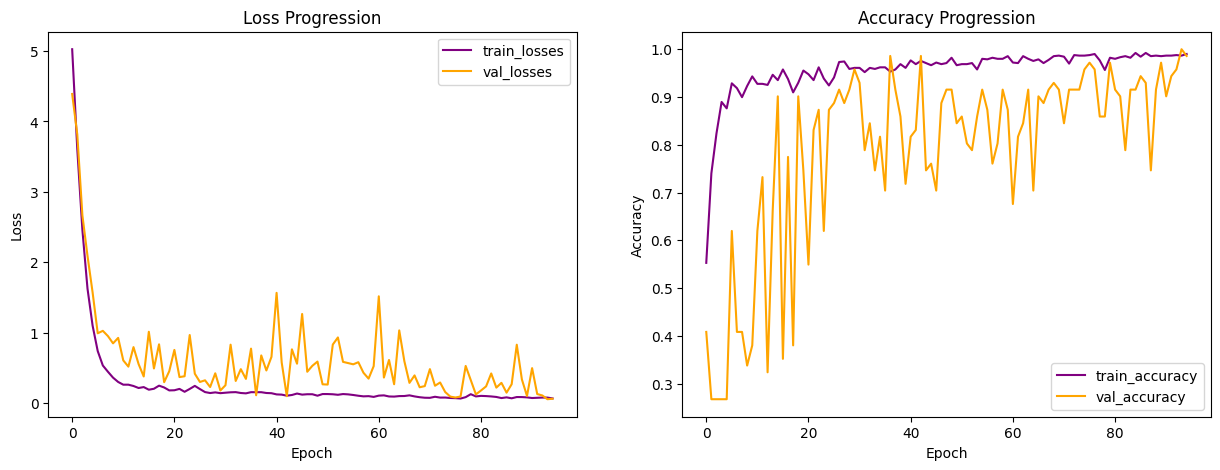

In [ ]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      validation_audio_features,
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

##Graphs

In [ ]:
# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_chroma_rms_spectral_centroid'] = model.evaluate(training_audio_features,
                                                         audio_df['train']['label'])[-1]

29/29 [==============================] - 3s 87ms/step - loss: 0.1947 - accuracy: 0.9420 - weighted_accuracy: 0.9420


In [ ]:
val_yhat = model.predict(validation_audio_features)

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_chroma_rms_spectral_centroid'] = model.evaluate(validation_audio_features,
                                                         audio_df['val']['label'])[-1]

3/3 [==============================] - 0s 62ms/step - loss: 0.1085 - accuracy: 0.9577 - weighted_accuracy: 0.9577


In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

                         precision    recall  f1-score   support

Scarlet-chested Sunbird       1.00      0.80      0.89       238
     Red-chested Cuckoo       0.97      0.99      0.98       345
         Egyptian Goose       0.88      1.00      0.94       314

               accuracy                           0.94       897
              macro avg       0.95      0.93      0.93       897
           weighted avg       0.95      0.94      0.94       897



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

                         precision    recall  f1-score   support

Scarlet-chested Sunbird       1.00      0.93      0.96        14
     Red-chested Cuckoo       0.90      1.00      0.95        19
         Egyptian Goose       0.97      0.95      0.96        38

               accuracy                           0.96        71
              macro avg       0.96      0.96      0.96        71
           weighted avg       0.96      0.96      0.96        71



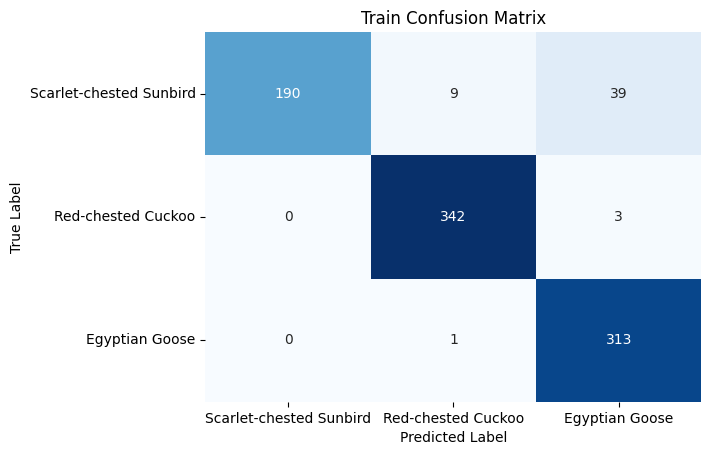

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

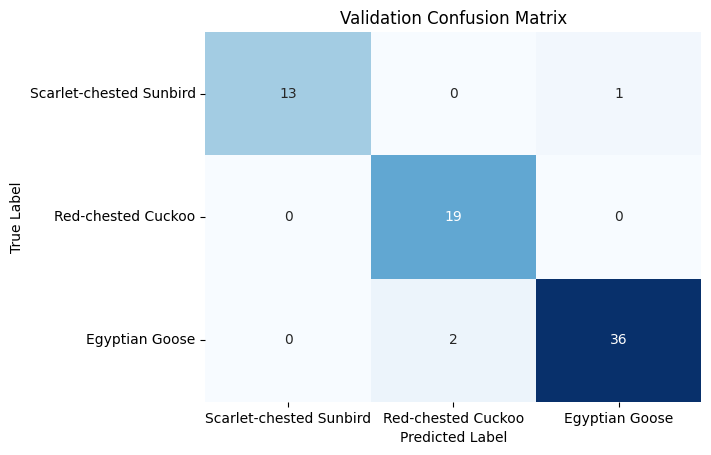

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

##save the model created

In [ ]:
# To test whether the model created is working or not.
import numpy as np
import librosa
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/my_model1.keras')

# Define a mapping of class indices to class names
class_names = {0: 'Scarlet-chested Sunbird', 1: 'Red-chested Cuckoo', 2: 'Egyptian Goose'}


def predict_audio(file_path):
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=None)

        # Extract MFCCs (21 MFCCs to match model input)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=21)

        # Ensure the time steps (frames) match the model's expected input (251 time steps in this case)
        required_time_steps = 251

        if mfccs.shape[1] < required_time_steps:
            # Pad with zeros if shorter
            pad_width = required_time_steps - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate if longer
            mfccs = mfccs[:, :required_time_steps]

        # Transpose the mfccs to have shape (251, 21) as expected by the model
        mfccs = mfccs.T  # Now mfccs will have shape (251, 21)

        # Reshape to match the model's input shape (1, 251, 21)
        audio_features = np.expand_dims(mfccs, axis=0)  # Add batch dimension

        # Make the prediction
        prediction = model.predict(audio_features)
        predicted_class = np.argmax(prediction, axis=-1)[0]  # Get the class with the highest probability

        # Get the class name from the mapping
        class_name = class_names.get(predicted_class, "Unknown")

        return class_name, prediction  # Return class name and probabilities

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

# Example usage:
file_path = '/content/drive/MyDrive/XC921114 - Egyptian Goose - Alopochen aegyptiaca.wav'
class_name, probabilities = predict_audio(file_path)

if class_name is not None:
    print(f"Predicted class: {class_name}")
    print(f"Probabilities: {probabilities}")

1/1 [==============================] - 0s 404ms/step
Predicted class: Red-chested Cuckoo
Probabilities: [[4.1310494e-05 9.9965262e-01 3.0604043e-04]]


In [ ]:
#  This will save the model in the google drive.
# model.save('/content/drive/MyDrive/my_model1.keras')